In [6]:
#!apt install libomp-dev
#!python -m pip install --upgrade faiss faiss-gpu
import faiss

In [4]:
pip install faiss-cpu

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 8.5 MB 1.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import tensorflow as tf
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import faiss
from matplotlib import pyplot as plt

In [46]:
# Defining 50 layer residual network : ResNet50 trained on million images, to get features for our dataset.
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

#Extracting features of images by including image path and model trained above
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [69]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = '/home/shreya/test'
filenames = sorted(get_file_list(root_dir))
print(filenames)

['/home/shreya/test/0.jpg', '/home/shreya/test/1.jpg', '/home/shreya/test/10.jpg', '/home/shreya/test/100.jpg', '/home/shreya/test/1000.jpg', '/home/shreya/test/1001.jpg', '/home/shreya/test/1002.jpg', '/home/shreya/test/1003.jpg', '/home/shreya/test/1004.jpg', '/home/shreya/test/1005.jpg', '/home/shreya/test/1006.jpg', '/home/shreya/test/1007.jpg', '/home/shreya/test/1008.jpg', '/home/shreya/test/1009.jpg', '/home/shreya/test/101.jpg', '/home/shreya/test/1010.jpg', '/home/shreya/test/1011.jpg', '/home/shreya/test/1012.jpg', '/home/shreya/test/1013.jpg', '/home/shreya/test/1014.jpg', '/home/shreya/test/1015.jpg', '/home/shreya/test/1016.jpg', '/home/shreya/test/1017.jpg', '/home/shreya/test/1018.jpg', '/home/shreya/test/1019.jpg', '/home/shreya/test/102.jpg', '/home/shreya/test/1020.jpg', '/home/shreya/test/1021.jpg', '/home/shreya/test/1022.jpg', '/home/shreya/test/1023.jpg', '/home/shreya/test/1024.jpg', '/home/shreya/test/1025.jpg', '/home/shreya/test/1026.jpg', '/home/shreya/test/1

In [70]:
import glob
img_lst = []
image_paths = glob.glob('/home/shreya/test/*.jpg')
for image_path in image_paths:
      img_lst.append(image_path)
print(image_paths)

['/home/shreya/test/456.jpg', '/home/shreya/test/916.jpg', '/home/shreya/test/804.jpg', '/home/shreya/test/1176.jpg', '/home/shreya/test/1163.jpg', '/home/shreya/test/56.jpg', '/home/shreya/test/775.jpg', '/home/shreya/test/1090.jpg', '/home/shreya/test/939.jpg', '/home/shreya/test/909.jpg', '/home/shreya/test/552.jpg', '/home/shreya/test/679.jpg', '/home/shreya/test/690.jpg', '/home/shreya/test/280.jpg', '/home/shreya/test/1325.jpg', '/home/shreya/test/619.jpg', '/home/shreya/test/1415.jpg', '/home/shreya/test/762.jpg', '/home/shreya/test/1159.jpg', '/home/shreya/test/1248.jpg', '/home/shreya/test/664.jpg', '/home/shreya/test/537.jpg', '/home/shreya/test/588.jpg', '/home/shreya/test/839.jpg', '/home/shreya/test/900.jpg', '/home/shreya/test/494.jpg', '/home/shreya/test/732.jpg', '/home/shreya/test/744.jpg', '/home/shreya/test/743.jpg', '/home/shreya/test/101.jpg', '/home/shreya/test/267.jpg', '/home/shreya/test/1323.jpg', '/home/shreya/test/1021.jpg', '/home/shreya/test/908.jpg', '/hom

In [71]:
#Sampling the dataset, as the program takes a lot of time to run
imglist = img_lst[:1500]

In [72]:
feature_list = []
for i in tqdm(range(len(imglist))):
    feature_list.append(extract_features(imglist[i], model))

  0%|          | 0/1500 [00:00<?, ?it/s]

In [73]:
features=np.array(feature_list)
features.shape

(1500, 100352)

In [82]:
dimensions=features.shape[1]
db_vectors=features 
nlist = 1  # number of clusters
quantiser = faiss.IndexFlatL2(dimensions) #to assign the vectors to a particular cluster. This is index that uses the L2 distance metric 
index = faiss.IndexIVFFlat(quantiser, dimensions, nlist,   faiss.METRIC_L2) #defining index

In [83]:
print(index.is_trained)   # False
index.train(db_vectors)  # train on the database vectors
print(index.ntotal)   # 0
index.add(db_vectors)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)

False
0
True
1500


In [76]:
nprobe = 1  # find 2 most similar clusters
n_query = 1000  
k = 10  # return 3 nearest neighbours
np.random.seed(0)   
#Trying out a random images at 23rd position in images folder :
distances, indices = index.search(features, k)

In [78]:
distances

array([[0.        , 0.9758335 , 0.9945197 , ..., 1.0230186 , 1.0235391 ,
        1.0283    ],
       [0.        , 1.1573377 , 1.1911324 , ..., 1.2216308 , 1.2268941 ,
        1.2285746 ],
       [0.        , 1.1722275 , 1.2288561 , ..., 1.3073794 , 1.3089752 ,
        1.3146896 ],
       ...,
       [0.        , 1.3316823 , 1.378664  , ..., 1.4397069 , 1.4426823 ,
        1.443074  ],
       [0.        , 0.89721996, 1.2149824 , ..., 1.3007269 , 1.3063785 ,
        1.3150946 ],
       [0.        , 0.8876565 , 0.9986263 , ..., 1.063193  , 1.0790284 ,
        1.0911882 ]], dtype=float32)

In [79]:
indices

array([[   0,  196, 1372, ..., 1294,   92,  977],
       [   1, 1150,  539, ..., 1218,    7,  355],
       [   2,  666, 1150, ..., 1413,  741,  561],
       ...,
       [1497,  517, 1337, ...,  289,  730,  161],
       [1498, 1217, 1308, ..., 1121,  572,   84],
       [1499,  176, 1442, ...,   77,  912, 1322]])

In [84]:
def faiss_similarity(img):
    feature_list=extract_features('/home/shreya/test/'+str(img), model)
    nprobe = 2  # find 2 most similar clusters
    n_query = 1  
    print(feature_list)
    k = 10  # return 10 nearest neighbours
    np.random.seed(0)
    dimensions=len(feature_list)   
    query_vectors = np.random.random((n_query, dimensions)).astype('float32')
    distances, indices = index.search(feature_list.reshape(1,-1), k)
    list_ind=indices.flatten().tolist()
    f, ax = plt.subplots(1, 10, figsize=(16, 8))
    for i,j in enumerate(list_ind):
        ax[i].imshow(plt.imread(imglist[j]))
        ax[i].set_axis_off()
    plt.show()


[0.        0.        0.        ... 0.        0.        0.0010181]


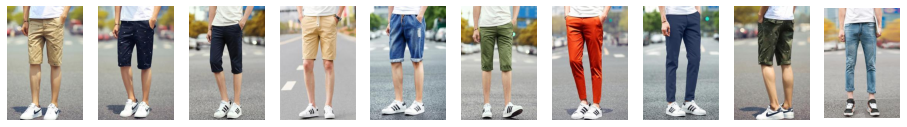

In [91]:
faiss_similarity('777.jpg')
#/home/shreya/test/10.jpeg

In [92]:
len(feature_list)

1500

In [93]:
len(imglist)
print(imglist)

['/home/shreya/test/456.jpg', '/home/shreya/test/916.jpg', '/home/shreya/test/804.jpg', '/home/shreya/test/1176.jpg', '/home/shreya/test/1163.jpg', '/home/shreya/test/56.jpg', '/home/shreya/test/775.jpg', '/home/shreya/test/1090.jpg', '/home/shreya/test/939.jpg', '/home/shreya/test/909.jpg', '/home/shreya/test/552.jpg', '/home/shreya/test/679.jpg', '/home/shreya/test/690.jpg', '/home/shreya/test/280.jpg', '/home/shreya/test/1325.jpg', '/home/shreya/test/619.jpg', '/home/shreya/test/1415.jpg', '/home/shreya/test/762.jpg', '/home/shreya/test/1159.jpg', '/home/shreya/test/1248.jpg', '/home/shreya/test/664.jpg', '/home/shreya/test/537.jpg', '/home/shreya/test/588.jpg', '/home/shreya/test/839.jpg', '/home/shreya/test/900.jpg', '/home/shreya/test/494.jpg', '/home/shreya/test/732.jpg', '/home/shreya/test/744.jpg', '/home/shreya/test/743.jpg', '/home/shreya/test/101.jpg', '/home/shreya/test/267.jpg', '/home/shreya/test/1323.jpg', '/home/shreya/test/1021.jpg', '/home/shreya/test/908.jpg', '/hom

In [94]:
imglist2 = []
for i in range(len(imglist)):
    imglist2.append(imglist[i])
print(len(imglist2))

1500


In [96]:
df_img = pd.DataFrame()
df_img['img'] = imglist2
df_img

,img
0,/home/shreya/test/456.jpg
1,/home/shreya/test/916.jpg
2,/home/shreya/test/804.jpg
3,/home/shreya/test/1176.jpg
4,/home/shreya/test/1163.jpg
...,...
1495,/home/shreya/test/1425.jpg
1496,/home/shreya/test/873.jpg
1497,/home/shreya/test/1498.jpg
1498,/home/shreya/test/862.jpg


In [97]:
df_indices = pd.DataFrame(indices)
imgref = df_img.to_dict()
imgref = imgref['img']
imgref

{0: '/home/shreya/test/456.jpg',
 1: '/home/shreya/test/916.jpg',
 2: '/home/shreya/test/804.jpg',
 3: '/home/shreya/test/1176.jpg',
 4: '/home/shreya/test/1163.jpg',
 5: '/home/shreya/test/56.jpg',
 6: '/home/shreya/test/775.jpg',
 7: '/home/shreya/test/1090.jpg',
 8: '/home/shreya/test/939.jpg',
 9: '/home/shreya/test/909.jpg',
 10: '/home/shreya/test/552.jpg',
 11: '/home/shreya/test/679.jpg',
 12: '/home/shreya/test/690.jpg',
 13: '/home/shreya/test/280.jpg',
 14: '/home/shreya/test/1325.jpg',
 15: '/home/shreya/test/619.jpg',
 16: '/home/shreya/test/1415.jpg',
 17: '/home/shreya/test/762.jpg',
 18: '/home/shreya/test/1159.jpg',
 19: '/home/shreya/test/1248.jpg',
 20: '/home/shreya/test/664.jpg',
 21: '/home/shreya/test/537.jpg',
 22: '/home/shreya/test/588.jpg',
 23: '/home/shreya/test/839.jpg',
 24: '/home/shreya/test/900.jpg',
 25: '/home/shreya/test/494.jpg',
 26: '/home/shreya/test/732.jpg',
 27: '/home/shreya/test/744.jpg',
 28: '/home/shreya/test/743.jpg',
 29: '/home/shreya

In [98]:
df_indices = df_indices.replace(imgref)
df_indices

,0,1,2,3,4,5,6,7,8,9
0,/home/shreya/test/456.jpg,/home/shreya/test/222.jpg,/home/shreya/test/572.jpg,/home/shreya/test/152.jpg,/home/shreya/test/1078.jpg,/home/shreya/test/1285.jpg,/home/shreya/test/365.jpg,/home/shreya/test/296.jpg,/home/shreya/test/18.jpg,/home/shreya/test/333.jpg
1,/home/shreya/test/916.jpg,/home/shreya/test/1334.jpg,/home/shreya/test/496.jpg,/home/shreya/test/735.jpg,/home/shreya/test/1102.jpg,/home/shreya/test/729.jpg,/home/shreya/test/1165.jpg,/home/shreya/test/728.jpg,/home/shreya/test/1090.jpg,/home/shreya/test/486.jpg
2,/home/shreya/test/804.jpg,/home/shreya/test/128.jpg,/home/shreya/test/1334.jpg,/home/shreya/test/1131.jpg,/home/shreya/test/1371.jpg,/home/shreya/test/724.jpg,/home/shreya/test/947.jpg,/home/shreya/test/1309.jpg,/home/shreya/test/788.jpg,/home/shreya/test/310.jpg
3,/home/shreya/test/1176.jpg,/home/shreya/test/1056.jpg,/home/shreya/test/570.jpg,/home/shreya/test/403.jpg,/home/shreya/test/1133.jpg,/home/shreya/test/1135.jpg,/home/shreya/test/874.jpg,/home/shreya/test/749.jpg,/home/shreya/test/1152.jpg,/home/shreya/test/1431.jpg
4,/home/shreya/test/1163.jpg,/home/shreya/test/1310.jpg,/home/shreya/test/652.jpg,/home/shreya/test/511.jpg,/home/shreya/test/1171.jpg,/home/shreya/test/1155.jpg,/home/shreya/test/241.jpg,/home/shreya/test/811.jpg,/home/shreya/test/931.jpg,/home/shreya/test/170.jpg
...,...,...,...,...,...,...,...,...,...,...
1495,/home/shreya/test/1425.jpg,/home/shreya/test/1418.jpg,/home/shreya/test/1417.jpg,/home/shreya/test/1030.jpg,/home/shreya/test/84.jpg,/home/shreya/test/930.jpg,/home/shreya/test/1341.jpg,/home/shreya/test/1225.jpg,/home/shreya/test/498.jpg,/home/shreya/test/1177.jpg
1496,/home/shreya/test/873.jpg,/home/shreya/test/222.jpg,/home/shreya/test/448.jpg,/home/shreya/test/1042.jpg,/home/shreya/test/771.jpg,/home/shreya/test/427.jpg,/home/shreya/test/1320.jpg,/home/shreya/test/236.jpg,/home/shreya/test/946.jpg,/home/shreya/test/515.jpg
1497,/home/shreya/test/1498.jpg,/home/shreya/test/789.jpg,/home/shreya/test/845.jpg,/home/shreya/test/503.jpg,/home/shreya/test/1423.jpg,/home/shreya/test/848.jpg,/home/shreya/test/1291.jpg,/home/shreya/test/58.jpg,/home/shreya/test/825.jpg,/home/shreya/test/1297.jpg
1498,/home/shreya/test/862.jpg,/home/shreya/test/857.jpg,/home/shreya/test/84.jpg,/home/shreya/test/702.jpg,/home/shreya/test/856.jpg,/home/shreya/test/725.jpg,/home/shreya/test/532.jpg,/home/shreya/test/1491.jpg,/home/shreya/test/498.jpg,/home/shreya/test/1341.jpg


In [99]:
df_indices.to_csv('Faiss.csv')